In [1]:
#ALGORITHM = 'XG Boost'
#ALGORITHM = 'Linear Regression (Ridge)'
#ALGORITHM = 'KNN'
ALGORITHM = 'Decision Tree'

ALGORITHM_DETAIL = 'random search'
DATA_DETAIL = []
#DATA_DETAIL = ['no scale','no dummies']
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

print(f'ALGORITHM: {ALGORITHM}')
print(f'ALGORITHM_DETAIL: {ALGORITHM_DETAIL}')
print(f'DATA_DETAIL: {DATA_DETAIL}')
print(f'DATA VERSION: {VERSION}')


ALGORITHM: Decision Tree
ALGORITHM_DETAIL: random search
DATA_DETAIL: []
DATA VERSION: 06


In [2]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())
print(env_vars)

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None
#if quick_mode:OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_20221109 import set_csv_directory, get_columns
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters

    set_csv_directory('final_split')
else:
    cloud_run = True
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    from functions_20221109 import set_csv_directory, get_columns
    #from functions_20221109 import add_supplements, get_combined_dataset
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters


{'notebook_environment': 'gradient', 'use_gpu': True, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

starter_pipe = Pipeline([
    #('mms', MinMaxScaler()),
    ('std_scaler', StandardScaler()),
    ('model', get_chosen_model(ALGORITHM))
])
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model', DecisionTreeRegressor())])

In [4]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [5]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if cloud_run:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [6]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v06.csv
(46871, 9)


In [7]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD


In [8]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [9]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [10]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [11]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [12]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895


In [13]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)


(39714, 11) (4413, 11) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [14]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [15]:
fitted_graph_model = starter_pipe[-1]
default_model_params = fitted_graph_model.get_params()
default_model_params

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [16]:
import sklearn

sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [17]:
%timeit starter_pipe.fit(X_train, y_train)

345 ms ± 7.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
options_block = get_hyperparameters(ALGORITHM, use_gpu)

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS)

print("cv:", cv, "n_jobs:", n_jobs, "refit:", refit, "n_iter:", n_iter, "verbose:", verbose)
param_options

cv: 3 n_jobs: 3 refit: True n_iter: 100 verbose: 1


{'model__splitter': ['best', 'random'],
 'model__random_state': [None],
 'model__min_weight_fraction_leaf': [0.0, 0.1, 0.25, 0.5],
 'model__min_samples_split': [2, 4, 8, 50, 100, 200, 500],
 'model__min_samples_leaf': [1, 0.25, 0.5, 1.5, 2, 4, 8, 50],
 'model__min_impurity_decrease': [0.0, 0.1, 0.25, 1, 5],
 'model__max_leaf_nodes': [None, 2, 5, 10, 50, 100, 200, 500],
 'model__max_features': [None, 1.0, 'sqrt', 'log2', 0.5, 0.25, 0.1, 2],
 'model__max_depth': [None, 1, 2, 5, 10, 50],
 'model__criterion': ['squared_error',
  'friedman_mse',
  'absolute_error',
  'poisson'],
 'model__ccp_alpha': [0.0, 0.05, 0.1, 0.25, 1, 5]}

In [19]:
def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


crossval_runner = RandomizedSearchCV(
    estimator=starter_pipe,
    param_distributions=param_options,
    cv=cv, n_jobs=n_jobs,  # get the AVX/AVX2 info if use n_jobs > 2
    verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
    refit=refit,
    return_train_score=True,  #n_iter=n_iter,
    n_iter=n_iter,  # 1, #3
    #error_score='raise'
)

cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
    crossval_runner, X_train, y_train, fits=cv * n_iter)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Total fit/CV time      : 365 seconds   (1668292235.0495834 ==> 1668292600.562413)

average fit/score time = 1.23s/0.0s
max fit/score time     = 33.18s/0.0s
refit time             = 0.22s


In [20]:
crossval_runner.best_params_
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model', DecisionTreeRegressor())])

In [21]:
best_estimator_pipe = crossval_runner.best_estimator_

if debug_mode:
    crossval_runner.cv_results_

In [22]:
cv_results_df = pd.DataFrame(crossval_runner.cv_results_).sort_values('rank_test_score')
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__splitter,param_model__random_state,param_model__min_weight_fraction_leaf,param_model__min_samples_split,param_model__min_samples_leaf,param_model__min_impurity_decrease,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
58,0.134666,0.001610,0.002944,0.000048,best,None,0.0,4,8,0.1,...,0.589335,0.599003,0.595488,0.004366,1,0.653575,0.653871,0.650661,0.652702,0.001449
85,33.181943,0.509198,0.002844,0.000117,best,None,0.0,8,8,5,...,0.511007,0.534275,0.520243,0.010086,2,0.535010,0.537564,0.532419,0.534998,0.002100
5,0.090677,0.002127,0.002798,0.000353,best,None,0.0,500,8,0.0,...,0.374381,0.395763,0.385203,0.008731,3,0.391632,0.391680,0.389493,0.390935,0.001020
57,0.041443,0.001187,0.002338,0.000268,best,None,0.0,500,1,0.0,...,0.357710,0.382202,0.364740,0.012426,4,0.356031,0.376219,0.380706,0.370985,0.010732
67,0.069803,0.001642,0.002359,0.000077,best,None,0.1,200,1,0.1,...,0.311442,0.324146,0.315405,0.006189,5,0.321251,0.319181,0.314093,0.318175,0.003008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,0.011761,0.000236,0.001732,0.000077,best,None,0.1,200,1.5,0.0,...,-0.000022,-0.000116,-0.000059,0.000041,82,0.000000,0.000000,0.000000,0.000000,0.000000
10,0.013051,0.000403,0.001855,0.000137,best,None,0.5,50,1.5,0.1,...,-0.000022,-0.000116,-0.000059,0.000041,82,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.013524,0.000565,0.002562,0.000487,random,None,0.5,100,1,0.25,...,-0.000022,-0.000116,-0.000059,0.000041,82,0.000000,0.000000,0.000000,0.000000,0.000000
71,0.012446,0.000670,0.001968,0.000044,random,None,0.0,2,1.5,5,...,-0.000022,-0.000116,-0.000059,0.000041,82,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
if debug_mode:
    xx = [c for c in cv_results_df.columns if 'param' in c]
    xx.insert(0, 'rank_test_score')
    xx.insert(0, 'mean_test_score')
    cv_results_df[xx].head(7)

In [24]:
if debug_mode:
    cv_results_df[xx].tail(7)

In [25]:
cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
# if 'Neural' not in ALGORITHM:
#     cv_columns.insert(2, 'mean_train_score')
cv_results_df_full_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)
cv_results_df_full_sorted

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,best/None/0.0/4/8/0.1/500/None/10/squared_error/1,1,0.595488,0.134666,0.002944,"{'model__splitter': 'best', 'model__random_sta..."
1,best/None/0.0/8/8/5/50/1.0/None/absolute_error/5,2,0.520243,33.181943,0.002844,"{'model__splitter': 'best', 'model__random_sta..."
2,best/None/0.0/500/8/0.0/10/None/10/friedman_ms...,3,0.385203,0.090677,0.002798,"{'model__splitter': 'best', 'model__random_sta..."
3,best/None/0.0/500/1/0.0/10/0.5/5/friedman_mse/5,4,0.364740,0.041443,0.002338,"{'model__splitter': 'best', 'model__random_sta..."
4,best/None/0.1/200/1/0.1/50/1.0/10/poisson/5,5,0.315405,0.069803,0.002359,"{'model__splitter': 'best', 'model__random_sta..."
...,...,...,...,...,...,...
95,random/None/0.1/2/50/0.1/100/0.1/10/poisson/0.05,82,-0.000059,0.012049,0.001762,"{'model__splitter': 'random', 'model__random_s..."
96,random/None/0.5/2/1/5/10/None/10/poisson/0.05,82,-0.000059,0.013919,0.001822,"{'model__splitter': 'random', 'model__random_s..."
97,random/None/0.5/8/8/0.1/2/sqrt/None/friedman_m...,82,-0.000059,0.011901,0.001965,"{'model__splitter': 'random', 'model__random_s..."
98,best/None/0.5/500/1/1/500/0.1/5/squared_error/0.1,82,-0.000059,0.013273,0.001888,"{'model__splitter': 'best', 'model__random_sta..."


In [26]:
cv_results_df_sorted = cv_results_df_full_sorted[cv_results_df_full_sorted['mean_test_score'] > -2]
if len(cv_results_df_sorted) != len(cv_results_df_full_sorted):
    print(-len(cv_results_df_sorted) + len(cv_results_df_full_sorted), "fits were total failures")
    total_fits = len(cv_results_df_sorted)
cv_results_df_sorted


,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,best/None/0.0/4/8/0.1/500/None/10/squared_error/1,1,0.595488,0.134666,0.002944,"{'model__splitter': 'best', 'model__random_sta..."
1,best/None/0.0/8/8/5/50/1.0/None/absolute_error/5,2,0.520243,33.181943,0.002844,"{'model__splitter': 'best', 'model__random_sta..."
2,best/None/0.0/500/8/0.0/10/None/10/friedman_ms...,3,0.385203,0.090677,0.002798,"{'model__splitter': 'best', 'model__random_sta..."
3,best/None/0.0/500/1/0.0/10/0.5/5/friedman_mse/5,4,0.364740,0.041443,0.002338,"{'model__splitter': 'best', 'model__random_sta..."
4,best/None/0.1/200/1/0.1/50/1.0/10/poisson/5,5,0.315405,0.069803,0.002359,"{'model__splitter': 'best', 'model__random_sta..."
...,...,...,...,...,...,...
95,random/None/0.1/2/50/0.1/100/0.1/10/poisson/0.05,82,-0.000059,0.012049,0.001762,"{'model__splitter': 'random', 'model__random_s..."
96,random/None/0.5/2/1/5/10/None/10/poisson/0.05,82,-0.000059,0.013919,0.001822,"{'model__splitter': 'random', 'model__random_s..."
97,random/None/0.5/8/8/0.1/2/sqrt/None/friedman_m...,82,-0.000059,0.011901,0.001965,"{'model__splitter': 'random', 'model__random_s..."
98,best/None/0.5/500/1/1/500/0.1/5/squared_error/0.1,82,-0.000059,0.013273,0.001888,"{'model__splitter': 'best', 'model__random_sta..."


In [27]:
def print_results(cross_validation_result):
    means = cross_validation_result.cv_results_['mean_test_score']
    stds = cross_validation_result.cv_results_['std_test_score']
    params = cross_validation_result.cv_results_['params']
    times = cross_validation_result.cv_results_['std_test_score']

    print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
    print()
    for mean, std, param, time in zip(means, stds, params, times):
        #param2 = "/".join(list(param.values()))
        param2 = "/".join(list([str(c) for c in param.values()]))
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')


if debug_mode:
    print_results(crossval_runner)

In [28]:
print('Best Index: ', crossval_runner.best_index_)
print('Best Score: ', crossval_runner.best_score_)
print('Best Params: ', crossval_runner.best_params_)

Best Index:  58
Best Score:  0.5954883877728088
Best Params:  {'model__splitter': 'best', 'model__random_state': None, 'model__min_weight_fraction_leaf': 0.0, 'model__min_samples_split': 4, 'model__min_samples_leaf': 8, 'model__min_impurity_decrease': 0.1, 'model__max_leaf_nodes': 500, 'model__max_features': None, 'model__max_depth': 10, 'model__criterion': 'squared_error', 'model__ccp_alpha': 1}


In [29]:
y_pred = best_estimator_pipe.predict(X_test)

In [31]:
y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Decision Tree----------
R square Accuracy 0.6166691700061457
Mean Absolute Error Accuracy 51363.90583275844
Mean Squared Error Accuracy 4330260545.639147
Root Mean Squared Error 65804.71522344844


In [32]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [33]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754,400000.0,354171.875000,45828.125000,11.457031,12.939516
119328242,369950.0,403989.153153,34039.153153,9.201015,8.425759
125716790,350000.0,420315.254386,70315.254386,20.090073,16.729170
122440040,549000.0,475807.195269,73192.804731,13.332023,15.382871
120508103,495000.0,515050.648876,20050.648876,4.050636,3.892947
...,...,...,...,...,...
68620869,475000.0,543245.977011,68245.977011,14.367574,12.562629
85735665,575000.0,554154.490196,20845.509804,3.625306,3.761678
125706338,400000.0,376772.265385,23227.734615,5.806934,6.164927


In [34]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'],
                                                                                                     ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']] = combined[
    ['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
122265818,160000,531664,371664.705882,232.290441,69.905845,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
109722224,108000,315756,207756.250000,192.366898,65.796401,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
85667184,122000,325518,203518.708333,166.818613,62.521355,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD
83639617,190000,448469,258469.933333,136.036807,57.633726,190000,2,2,0.162816,51.491264,0.064660,0.008456,0.169080,LEASEHOLD
123509066,232000,513254,281254.565141,121.230416,54.798259,232000,1,1,0.153684,51.512190,-0.134790,0.012470,0.030370,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124100615,335000,335154,154.990909,0.046266,0.046245,335000,2,1,0.889697,51.542613,-0.439712,0.042893,0.335292,LEASEHOLD
124443710,335000,334917,82.131148,0.024517,0.024523,335000,1,1,0.335897,51.587751,-0.096142,0.088031,0.008278,LEASEHOLD
123513026,399995,399999,4.218750,0.001055,0.001055,399995,2,2,0.264080,51.407970,-0.004300,0.091750,0.100120,LEASEHOLD
114664079,400000,399999,0.781250,0.000195,0.000195,400000,2,2,0.558712,51.410053,0.033548,0.089667,0.137968,LEASEHOLD


In [35]:
score = best_estimator_pipe.score(X_test, y_test)
score

0.6166691700061457

In [36]:
r2_score(y_test, y_pred)

0.6166691700061457

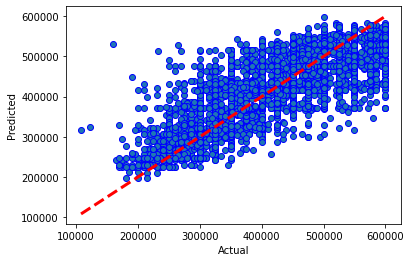

In [37]:
fig, ax = plt.subplots()
ax.scatter(y_test, best_estimator_pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [38]:
def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
    graph_model = model
    graph_model.set_params(**graph_params)
    graph_model.fit(X_train, y_train)
    y_pred_graph = model.predict(X_test)

    return model, y_pred_graph


best_model_count = 10 if not quick_mode else 2
best_model_count = 3 if not quick_mode else 1
best_models = {}
best_model_predictions = {}
best_model_scores = {}

showable_increment = total_fits // (4 if not quick_mode else 2)
for i in range(0, total_fits, showable_increment):
    if debug_mode or True: print(f'{i} ==> {i}')

    if i == 0:
        fitted_graph_model = crossval_runner.best_estimator_
        y_pred_graph = y_pred
    else:
        graph_pipe_params = cv_results_df_sorted['params'][i]
        print(graph_pipe_params)
        # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

        graph_params = {}
        for key, value in graph_pipe_params.items():
            graph_params[key.replace('model__', '')] = value

        fitted_graph_model, y_pred_graph = custom_model_and_predictions(starter_pipe, graph_pipe_params, X_train,
                                                                        y_train, X_test)

    best_models[i] = fitted_graph_model[-1].get_params()
    best_model_predictions[i] = y_pred_graph
    best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

if debug_mode or True: print(f'{-1} ==> {-1}')
graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
print(graph_pipe_params)
graph_params = {}
for key, value in graph_pipe_params.items():
    graph_params[key.replace('model__', '')] = value
fitted_graph_model, y_pred_graph = custom_model_and_predictions(starter_pipe, graph_pipe_params, X_train,
                                                                y_train, X_test)
best_models[-1] = fitted_graph_model[-1].get_params()
best_model_predictions[-1] = y_pred_graph
best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


0 ==> 0
25 ==> 25
{'model__splitter': 'best', 'model__random_state': None, 'model__min_weight_fraction_leaf': 0.25, 'model__min_samples_split': 500, 'model__min_samples_leaf': 4, 'model__min_impurity_decrease': 0.25, 'model__max_leaf_nodes': 100, 'model__max_features': 'sqrt', 'model__max_depth': 10, 'model__criterion': 'poisson', 'model__ccp_alpha': 0.25}
50 ==> 50
{'model__splitter': 'best', 'model__random_state': None, 'model__min_weight_fraction_leaf': 0.25, 'model__min_samples_split': 100, 'model__min_samples_leaf': 50, 'model__min_impurity_decrease': 1, 'model__max_leaf_nodes': 500, 'model__max_features': 0.1, 'model__max_depth': None, 'model__criterion': 'friedman_mse', 'model__ccp_alpha': 5}
75 ==> 75
{'model__splitter': 'random', 'model__random_state': None, 'model__min_weight_fraction_leaf': 0.0, 'model__min_samples_split': 50, 'model__min_samples_leaf': 1.5, 'model__min_impurity_decrease': 5, 'model__max_leaf_nodes': 500, 'model__max_features': 2, 'model__max_depth': 5, 'mod

In [39]:
cv_results_df_sorted

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,best/None/0.0/4/8/0.1/500/None/10/squared_error/1,1,0.595488,0.134666,0.002944,"{'model__splitter': 'best', 'model__random_sta..."
1,best/None/0.0/8/8/5/50/1.0/None/absolute_error/5,2,0.520243,33.181943,0.002844,"{'model__splitter': 'best', 'model__random_sta..."
2,best/None/0.0/500/8/0.0/10/None/10/friedman_ms...,3,0.385203,0.090677,0.002798,"{'model__splitter': 'best', 'model__random_sta..."
3,best/None/0.0/500/1/0.0/10/0.5/5/friedman_mse/5,4,0.364740,0.041443,0.002338,"{'model__splitter': 'best', 'model__random_sta..."
4,best/None/0.1/200/1/0.1/50/1.0/10/poisson/5,5,0.315405,0.069803,0.002359,"{'model__splitter': 'best', 'model__random_sta..."
...,...,...,...,...,...,...
95,random/None/0.1/2/50/0.1/100/0.1/10/poisson/0.05,82,-0.000059,0.012049,0.001762,"{'model__splitter': 'random', 'model__random_s..."
96,random/None/0.5/2/1/5/10/None/10/poisson/0.05,82,-0.000059,0.013919,0.001822,"{'model__splitter': 'random', 'model__random_s..."
97,random/None/0.5/8/8/0.1/2/sqrt/None/friedman_m...,82,-0.000059,0.011901,0.001965,"{'model__splitter': 'random', 'model__random_s..."
98,best/None/0.5/500/1/1/500/0.1/5/squared_error/0.1,82,-0.000059,0.013273,0.001888,"{'model__splitter': 'best', 'model__random_sta..."


In [40]:
if debug_mode:
    cv_results_df_sorted['params']

In [41]:
cv_results_df_sorted['params'][0]

{'model__splitter': 'best',
 'model__random_state': None,
 'model__min_weight_fraction_leaf': 0.0,
 'model__min_samples_split': 4,
 'model__min_samples_leaf': 8,
 'model__min_impurity_decrease': 0.1,
 'model__max_leaf_nodes': 500,
 'model__max_features': None,
 'model__max_depth': 10,
 'model__criterion': 'squared_error',
 'model__ccp_alpha': 1}

In [42]:
total_fits

100

In [43]:
best_models

{0: {'ccp_alpha': 0.05,
  'criterion': 'squared_error',
  'max_depth': 10,
  'max_features': 1.0,
  'max_leaf_nodes': 200,
  'min_impurity_decrease': 1,
  'min_samples_leaf': 8,
  'min_samples_split': 8,
  'min_weight_fraction_leaf': 0.0,
  'random_state': None,
  'splitter': 'best'},
 25: {'ccp_alpha': 0.25,
  'criterion': 'poisson',
  'max_depth': 10,
  'max_features': 'sqrt',
  'max_leaf_nodes': 100,
  'min_impurity_decrease': 0.25,
  'min_samples_leaf': 4,
  'min_samples_split': 500,
  'min_weight_fraction_leaf': 0.25,
  'random_state': None,
  'splitter': 'best'},
 50: {'ccp_alpha': 5,
  'criterion': 'friedman_mse',
  'max_depth': None,
  'max_features': 0.1,
  'max_leaf_nodes': 500,
  'min_impurity_decrease': 1,
  'min_samples_leaf': 50,
  'min_samples_split': 100,
  'min_weight_fraction_leaf': 0.25,
  'random_state': None,
  'splitter': 'best'},
 75: {'ccp_alpha': 0.0,
  'criterion': 'absolute_error',
  'max_depth': 5,
  'max_features': 2,
  'max_leaf_nodes': 500,
  'min_impurit

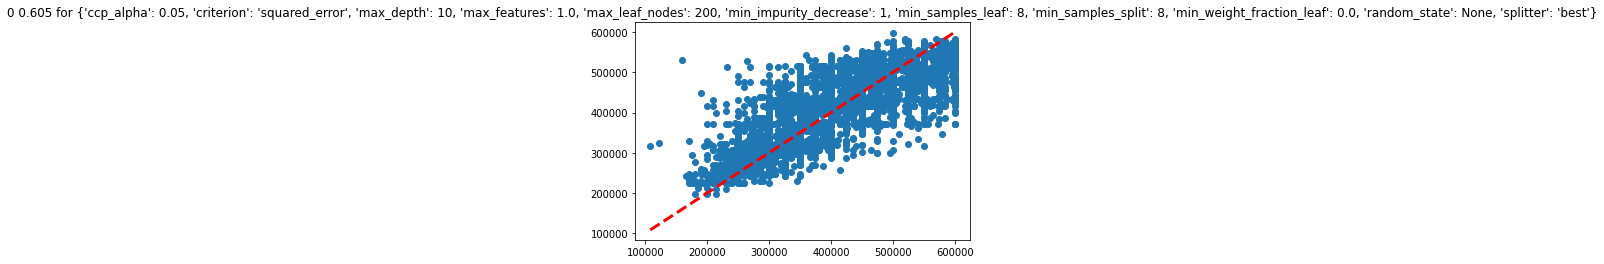

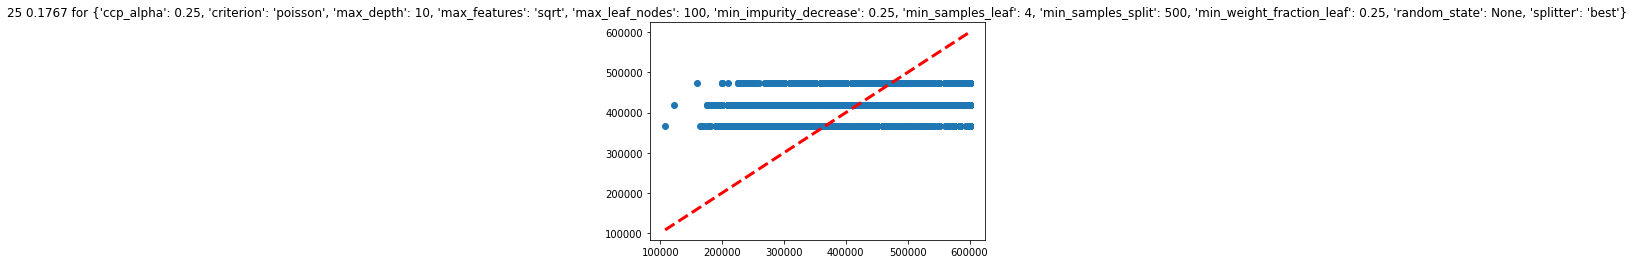

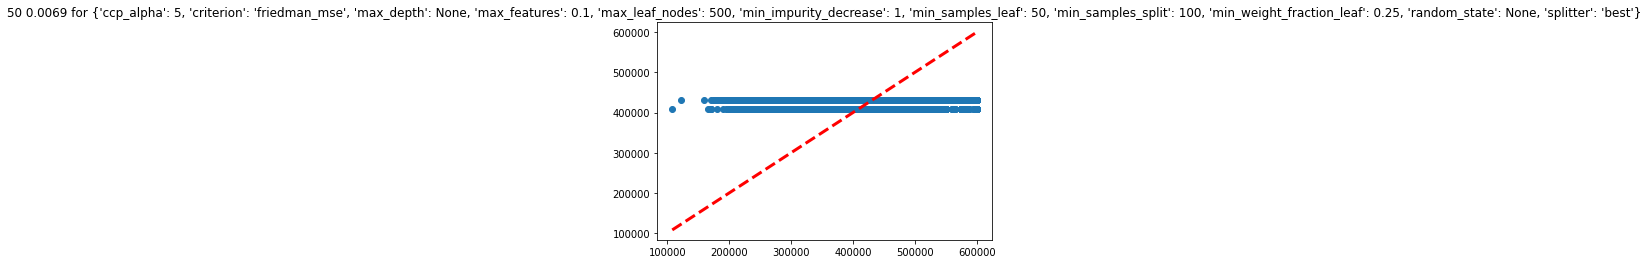

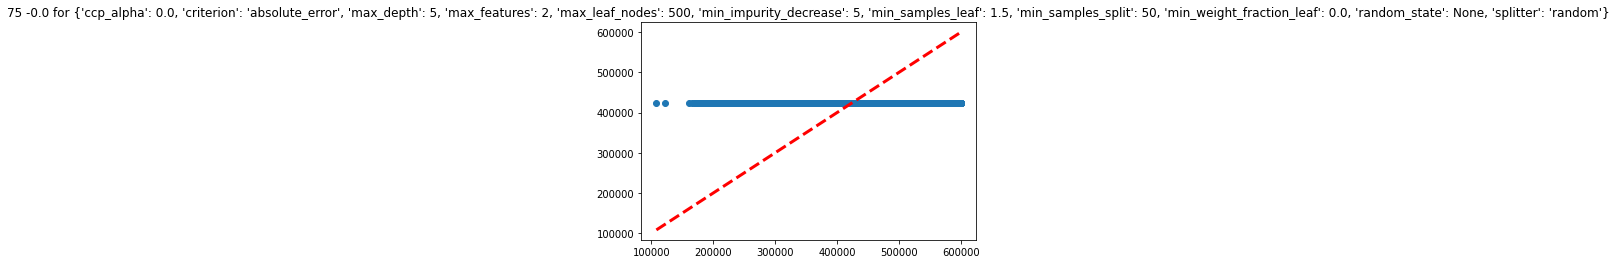

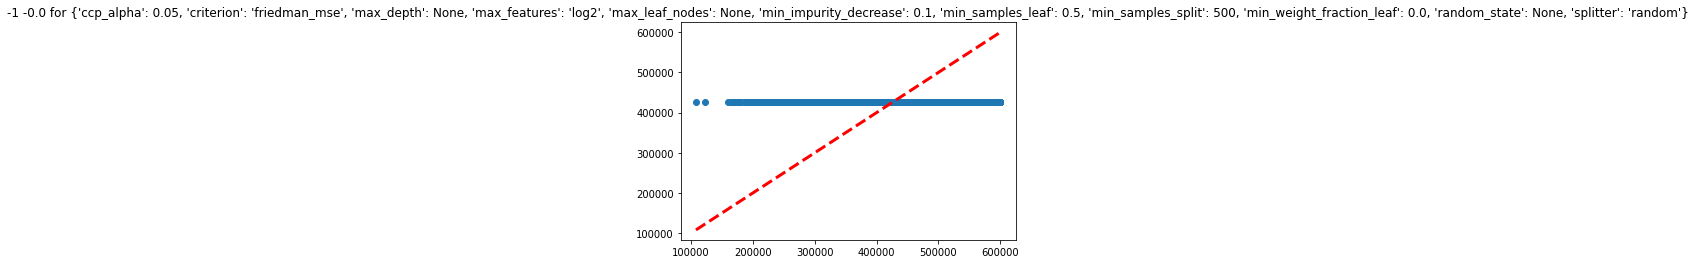

In [44]:
for i in best_model_scores.keys():
    if i >= 0:
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
        plt.scatter(y_test, best_model_predictions[i])
        # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
        if len(best_models[i].keys()) < 30:
            plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
        else:
            plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
        plt.show()

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.scatter(y_test, best_model_predictions[-1])
# plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
if len(best_models[i].keys()) < 30:
    plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for " + str(best_models[-1]))
else:
    plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i))

plt.show()

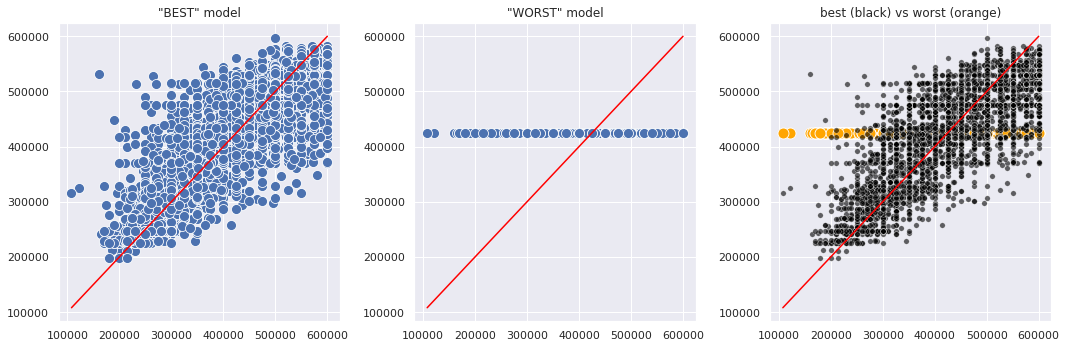

In [45]:
if True:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [46]:
cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
cv_best_model_fit_time

0.13466596603393555

In [47]:
cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]

DD2 = "(".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} - {ALGORITHM_DETAIL}{DD2} (v{VERSION})'.lower()

results = {
    '_score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    '_params': crossval_runner.best_params_,
    'run_env': run_env
}

if run_env not in ['colab']:
    results_json = get_results()
    this_model_is_best = update_results(results_json, results, key)

print(key)

decision tree - random search (v06)


In [48]:
crossval_runner.best_estimator_

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 DecisionTreeRegressor(ccp_alpha=0.05, max_depth=10,
                                       max_features=1.0, max_leaf_nodes=200,
                                       min_impurity_decrease=1,
                                       min_samples_leaf=8,
                                       min_samples_split=8))])

In [49]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        pickle.dump(crossval_runner.best_estimator_, f)
        print('pickled new version of model')
else:
    print("not updated saved model, the previous run was better")
    print(results_json[key]['best score'], 'better than', results_json[key]['_score'])

not updated saved model, the previous run was better
0.6168107520516921 better than 0.6166691700061457


In [50]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or ALGORITHM.lower() == 'xg boost':
    feature_importances = crossval_runner.best_estimator_[-1].feature_importances_
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

    indices = np.argsort(feature_importances)[::-1]

    print('Feature Ranking:')

    for f in range(X_train.shape[1]):
        print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]),
              df_features.columns[indices[f] + 1])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

Feature Ranking:
1. features 0 (0.368520) bedrooms
2. features 4 (0.212798) location.longitude
3. features 5 (0.156304) latitude_deviation
4. features 6 (0.078732) longitude_deviation
5. features 9 (0.058355) tenure.tenureType_LEASEHOLD
6. features 3 (0.057057) location.latitude
7. features 1 (0.042443) bathrooms
8. features 8 (0.015843) tenure.tenureType_FREEHOLD
9. features 2 (0.007216) nearestStation
10. features 10 (0.002732) tenure.tenureType_SHARE_OF_FREEHOLD
11. features 7 (0.000000) tenure.tenureType_COMMONHOLD


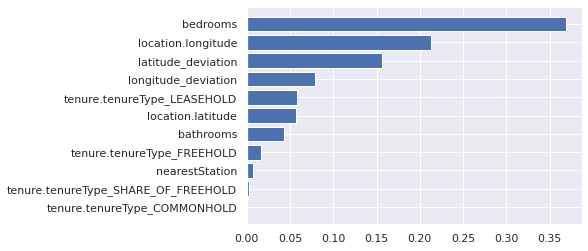

In [51]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or ALGORITHM.lower() == 'xg boost':
    feature_importances = crossval_runner.best_estimator_[-1].feature_importances_
    indices = np.argsort(feature_importances)

    fig, ax = plt.subplots()
    ax.barh(range(len(feature_importances)), feature_importances[indices])
    ax.set_yticks(range(len(feature_importances)))
    _ = ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')